In [1]:
import time
import numpy as np
import pandas as pd

import galsim #install with conda install -c conda_forge galsim

import matplotlib.pyplot as plt
from matplotlib import pyplot
import matplotlib.cm as cm
import matplotlib.colors as norm
from matplotlib.gridspec import SubplotSpec
import seaborn as sns

from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn import svm
from sklearn.svm import SVR

from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import cross_validate, KFold, StratifiedKFold
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score
from sklearn.inspection import permutation_importance
from sklearn.pipeline import make_pipeline #This allows one to build different steps together
from sklearn.preprocessing import StandardScaler, RobustScaler

from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

from tqdm import tqdm 

import target_predicting_RF_function_and_feature_ranking_TNGSIM as functions
import RF_target_predicting_and_learning_curves_functions_TNGSIM as tp_lc_functions

In [2]:
# Using the 0D TNG100 SIM data at z=0 (version 6 of the dataset that includes Mvir in this notebook, 
# for further explanation see Notebook v3 updated and v14)

df_0D = pd.read_csv('TNG-SIM_images/v3_initial_analysis/v6_TNG-SIM_0D_Dataset_wMvir.csv')
df_raw = pd.read_csv('TNG-SIM_images/v3_initial_analysis/v4_TNG-SIM_Raw_Dataset.csv')
print("df_0D.shape", df_0D.shape)
print("df_raw.shape", df_raw.shape)

df_0D.shape (21598, 17)
df_raw.shape (21598, 19)


## <font color='purple'> <a id =10> </a> <br> All morphologies w 5 most important features from SVR

### <font color='purple'> <a id =10> </a> <br> All morphologies Raw and 0D Dataset SR predicted 'best' equations 

In [3]:
# SR predicted 'best' equation for Rstar, using n_iter=10K
y_pred_SR_raw = 7.82e-7 * (1/df_raw.SubhaloStarMetallicity) * (df_raw.SubhaloMstar)**0.5
# SR_raw is simply Rstar = (7.82e-7) * (1/Zstar) * sqrt(Mstar)

# SR predicted 'best' equation for Rstar/Rvir, using n_iter=10K
y_pred_SR_0D = (1.85e-7) * (df_raw.SubhaloMstar/df_0D.SubhaloStarMetallicity**2) * (1 / df_0D.Group_M_TopHat200**0.72) *df_raw.Group_R_TopHat200

# SR_0D eqn is simply Rstar = (1.85e-7)*(Mstar/Zstar**2)*(1/Mvir**0.72)*Rvir

# SR raw and SR 0D predicted Rstar, and true Rstar


y_true = df_raw.loc[:, 'SubhaloRstar']
print(y_pred_SR_raw.shape)
print(y_true.shape)

print(y_pred_SR_0D.shape)

# Make a df with pred_true values to use w seaborn

df_pred_true = pd.DataFrame({'y_pred_SR_raw' : y_pred_SR_raw, 
                             'y_pred_SR_0D': y_pred_SR_0D,
                             'y_true' : df_raw.loc[:, 'SubhaloRstar']})

(21598,)
(21598,)
(21598,)


In [4]:
df_pred_true

,y_pred_SR_raw,y_pred_SR_0D,y_true
0,48.442134,39.582969,67.312584
1,53.786849,47.072111,125.480890
2,56.421061,56.610051,82.916380
3,37.663909,32.239008,28.387566
4,37.555492,27.928174,50.823353
...,...,...,...
21593,1.847266,3.422108,3.610431
21594,1.263200,1.909017,3.105893
21595,1.693650,3.289228,4.197745
21596,1.336082,2.159261,2.867348


In [8]:
r2_SR_raw = np.round(r2_score(y_true, y_pred_SR_raw), 2)
print('r2 SR_raw ', r2_SR_raw)
r2_SR_0D = np.round(r2_score(y_true, y_pred_SR_0D), 2)
print('r2 SR_0D ', r2_SR_0D)
mape_SR_raw = mean_absolute_percentage_error(y_true, y_pred_SR_raw)
mape_SR_0D = mean_absolute_percentage_error(y_true, y_pred_SR_0D)
print('mape SR_raw', mape_SR_raw )
print('mape SR_0D', mape_SR_0D )

r2 SR_raw  0.8
r2 SR_0D  0.78
mape SR_raw 0.2186863679726982
mape SR_0D 0.18685105160971152


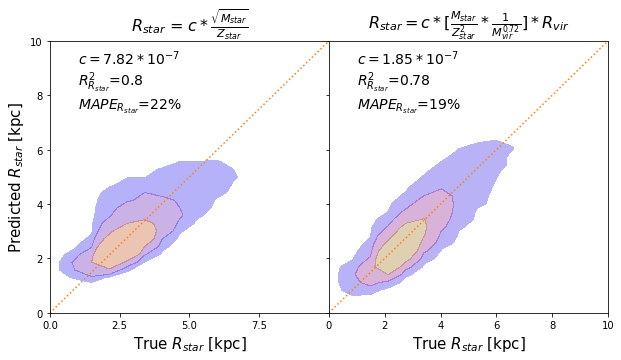

In [20]:
fig,[ax1, ax2]=plt.subplots(nrows=1,ncols=2, sharey=True, figsize=(10,5))
# fig.suptitle(r'TNG-SIM Galaxies, all morph: SR eqn Predicted vs True $R_{star}$ ', fontsize=16, fontweight='bold')
plt.subplots_adjust(hspace=0.0,wspace=0.0)

# label = (r'$R^{2}$={}' + '\n' + r'$MAPE_{Rstar}$={}$\%$'.format(r2_RF_dm, mape_RF_dm))
# label = r'$R^{2}_{R_{star}}$=0.66'+'\n'+r'$MAPE_{R_{star}}$=29$\%$'
# im1 = ax1.scatter(10**(df_raw_log.SubhaloRstar_log), 10**(y_pred_RF_dm), 
#                     s=3, marker='.', alpha=0.7, label=label) # , vmin=-2, vmax=1.0)

im1 = sns.kdeplot(data= df_pred_true, x='y_true', y = 'y_pred_SR_raw', alpha=0.3, gridsize=200, bw_adjust=0.5,
            levels = [0.1,0.25,0.5,1.0], ax = ax1, fill=True, cmap='brg') #,
#                  legend = r'$R^{2}_{R_{star}}$=0.85'+'\n'+r'$MAPE_{R_{star}}$=12$\%$')
# ax1.set_xlim([8.0, 11.5])
ax1.set_xticks([0.0, 2.5, 5.0, 7.5]) #, 10.0 ]) #, 12.5, 15.0, 17.5])
# ax1.set_ylim([-0.5,2.0])
ax1.axis([0.0,10.0, 0.0,10.0])
ax1.set_title(r'$R_{star}$ = $c * \frac{ \sqrt{M_{star}}}{Z_{star}}$', fontsize=16)
ax1.set_xlabel(r'True $R_{star}$ [kpc]', fontsize=15)
ax1.set_ylabel(r'Predicted $R_{star}$ [kpc]', fontsize=15)
ax1.annotate(r'$c=7.82*10^{-7}$' + '\n' +r'$R^{2}_{R_{star}}$=0.8'+'\n'+r'$MAPE_{R_{star}}$=22$\%$', (0.1,0.75), xycoords='axes fraction', size=14)
# ax1.legend(loc='upper left', shadow=True)
ax1.plot([0, 30], [0, 30],linestyle='dotted')

# label = r'$R^{2}_{R_{star}}$=0.67'+'\n'+r'$MAPE_{R_{star}}$=29$\%$'
# im2 = ax2.scatter(10**(df_raw_log.SubhaloRstar_log), 10**(y_pred_SVR_dm), 
#                      s=3, marker='.', alpha=0.7,label= label) #, vmin=-2, vmax=1.0)
im1 = sns.kdeplot(data= df_pred_true, x='y_true', y = 'y_pred_SR_0D', alpha=0.3, gridsize=200, bw_adjust=0.5,
            levels = [0.1,0.25,0.5,1.0], ax = ax2, fill=True, cmap='brg') #,
#                  label = label, legend=True)
# ax2.set_xlim([0.0,0.15])
# ax2.set_xticks([ 0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3])
# ax2.set_ylim([-3.0, 1.1])
ax2.axis([0.0,10.0, 0.0,10.0])
ax2.set_title(r'$R_{star}=c*[\frac{M_{star}}{Z_{star}^{2}}*\frac{1}{M_{vir}^{0.72}}]*R_{vir}$', fontsize=16)
ax2.set_xlabel(r'True $R_{star}$ [kpc]', fontsize=15)
ax2.annotate(r'$c=1.85*10^{-7}$' + '\n' + r'$R^{2}_{R_{star}}$=0.78'+'\n'+r'$MAPE_{R_{star}}$=19$\%$', (0.1,0.75), xycoords='axes fraction', size=14)
# ax2.set_ylabel(r'Predicted $R_{star}$ [kpc]')
# ax2.legend(loc='upper left' , shadow=True)
ax2.plot([0, 30], [0, 30],linestyle='dotted')

# fig.subplots_adjust(right=0.8)
# cbar_ax = fig.add_axes([0.85, 0.15, 0.01, 0.7])
# fig.colorbar(im2, cax=cbar_ax)

# plt.savefig("TNG-SIM_images/v29_fig_SReqn_allmorph_disks/v29_allmorph_TNG-SIM_SReqn_pred_true_KDEnotitle.pdf", dpi=500)
plt.show()

## <font color='purple'> <a id =10> </a> <br> Disks Dataset w all features 

In [23]:
df_disks_original = pd.read_csv('TNG-SIM_images/v24a_Disks_SVR_0DwMvir/v24a_TNG-SIM_Disks_Dataset_Raw.csv')
df_disks_log = pd.read_csv('TNG-SIM_images/v24a_Disks_SVR_0DwMvir/v24a_TNG-SIM_Disks_Dataset_LogRaw.csv')
df_disks_0D = pd.read_csv('TNG-SIM_images/v24a_Disks_SVR_0DwMvir/v24a_TNG-SIM_Disks_0D_wMvir_Dataset.csv')
df_disks_0D_log = pd.read_csv('TNG-SIM_images/v24a_Disks_SVR_0DwMvir/v24a_TNG-SIM_Disks_Log0D_wMvir_Dataset.csv')


### <font color='purple'> <a id =10> </a> <br> Disks Raw Dataset w all features

In [31]:
# SR predicted 'best' equation for Rstar on Disks, using n_iter=10K
y_pred_SR_raw_disks = (1.84e-11)*(df_disks_original.SubhaloMstar**(0.783))/df_disks_original.SubhaloStarMetallicity**2
# SR_raw is simply Rstar = a * (1/Zstar) * Mstar^0.783 / Zstar^2

# SR predicted 'best' equation for Rstar/Rvir on Disks, using n_iter=10K
y_pred_SR_0D_disks = 4.77e-8*((df_disks_original.SubhaloMstar/df_disks_0D.SubhaloStarMetallicity**2) *(1/df_disks_0D.Group_M_TopHat200**0.67))*df_disks_original.Group_R_TopHat200

# SR_0D eqn is simply Rstar = (4.77e-8)*(Mstar/Zstar**2)*(1/Mvir**0.67)*Rvir

# SR raw and SR 0D predicted Rstar, and true Rstar


y_true_disks = df_disks_original.loc[:, 'SubhaloRstar']
print(y_pred_SR_raw_disks.shape)
print(y_true_disks.shape)

print(y_pred_SR_0D_disks.shape)

# Make a df with pred_true values to use w seaborn

df_pred_true = pd.DataFrame({'y_pred_SR_raw_disks' : y_pred_SR_raw_disks, 
                             'y_pred_SR_0D_disks': y_pred_SR_0D_disks,
                             'y_true_disks' : df_disks_original.loc[:, 'SubhaloRstar']})

(3215,)
(3215,)
(3215,)


In [32]:
r2_SR_raw_disks = np.round(r2_score(y_true_disks, y_pred_SR_raw_disks), 2)
print('r2 SR_raw_disks ', r2_SR_raw_disks)
r2_SR_0D_disks = np.round(r2_score(y_true_disks, y_pred_SR_0D_disks), 2)
print('r2 SR_0D_disks ', r2_SR_0D_disks)
mape_SR_raw_disks = mean_absolute_percentage_error(y_true_disks, y_pred_SR_raw_disks)
mape_SR_0D_disks = mean_absolute_percentage_error(y_true_disks, y_pred_SR_0D_disks)
print('mape SR_raw_disks', mape_SR_raw_disks )
print('mape SR_0D_disks', mape_SR_0D_disks )

r2 SR_raw_disks  0.82
r2 SR_0D_disks  0.81
mape SR_raw_disks 0.18822053669470357
mape SR_0D_disks 0.19676979090005908


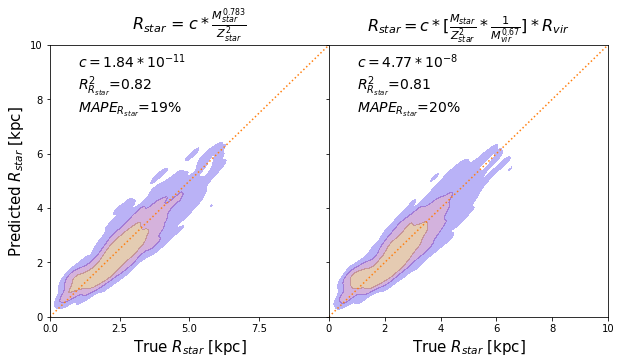

In [35]:
fig,[ax1, ax2]=plt.subplots(nrows=1,ncols=2, sharey=True, figsize=(10,5))
# fig.suptitle(r'TNG-SIM Galaxies, all morph: SR eqn Predicted vs True $R_{star}$ ', fontsize=16, fontweight='bold')
plt.subplots_adjust(hspace=0.0,wspace=0.0)

# label = (r'$R^{2}$={}' + '\n' + r'$MAPE_{Rstar}$={}$\%$'.format(r2_RF_dm, mape_RF_dm))
# label = r'$R^{2}_{R_{star}}$=0.66'+'\n'+r'$MAPE_{R_{star}}$=29$\%$'
# im1 = ax1.scatter(10**(df_raw_log.SubhaloRstar_log), 10**(y_pred_RF_dm), 
#                     s=3, marker='.', alpha=0.7, label=label) # , vmin=-2, vmax=1.0)

im1 = sns.kdeplot(data= df_pred_true, x='y_true_disks', y = 'y_pred_SR_raw_disks', alpha=0.3, gridsize=200, bw_adjust=0.5,
            levels = [0.1,0.25,0.5,1.0], ax = ax1, fill=True, cmap='brg') #,
#                  legend = r'$R^{2}_{R_{star}}$=0.85'+'\n'+r'$MAPE_{R_{star}}$=12$\%$')
# ax1.set_xlim([8.0, 11.5])
ax1.set_xticks([0.0, 2.5, 5.0, 7.5]) #, 10.0 ]) #, 12.5, 15.0, 17.5])
# ax1.set_ylim([-0.5,2.0])
ax1.axis([0.0,10.0, 0.0,10.0])
ax1.set_title(r'$R_{star}$ = $c * \frac{ M_{star}^{0.783}}{Z_{star}^{2}}$', fontsize=16)
ax1.set_xlabel(r'True $R_{star}$ [kpc]', fontsize=15)
ax1.set_ylabel(r'Predicted $R_{star}$ [kpc]', fontsize=15)
ax1.annotate(r'$c=1.84*10^{-11}$' + '\n' +r'$R^{2}_{R_{star}}$=0.82'+'\n'+r'$MAPE_{R_{star}}$=19$\%$', (0.1,0.75), xycoords='axes fraction', size=14)
# ax1.legend(loc='upper left', shadow=True)
ax1.plot([0, 30], [0, 30],linestyle='dotted')

# label = r'$R^{2}_{R_{star}}$=0.67'+'\n'+r'$MAPE_{R_{star}}$=29$\%$'
# im2 = ax2.scatter(10**(df_raw_log.SubhaloRstar_log), 10**(y_pred_SVR_dm), 
#                      s=3, marker='.', alpha=0.7,label= label) #, vmin=-2, vmax=1.0)
im1 = sns.kdeplot(data= df_pred_true, x='y_true_disks', y = 'y_pred_SR_0D_disks', alpha=0.3, gridsize=200, bw_adjust=0.5,
            levels = [0.1,0.25,0.5,1.0], ax = ax2, fill=True, cmap='brg') #,
#                  label = label, legend=True)
# ax2.set_xlim([0.0,0.15])
# ax2.set_xticks([ 0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3])
# ax2.set_ylim([-3.0, 1.1])
ax2.axis([0.0,10.0, 0.0,10.0])
ax2.set_title(r'$R_{star}=c*[\frac{M_{star}}{Z_{star}^{2}}*\frac{1}{M_{vir}^{0.67}}]*R_{vir}$', fontsize=16)
ax2.set_xlabel(r'True $R_{star}$ [kpc]', fontsize=15)
ax2.annotate(r'$c=4.77*10^{-8}$' + '\n' + r'$R^{2}_{R_{star}}$=0.81'+'\n'+r'$MAPE_{R_{star}}$=20$\%$', (0.1,0.75), xycoords='axes fraction', size=14)
# ax2.set_ylabel(r'Predicted $R_{star}$ [kpc]')
# ax2.legend(loc='upper left' , shadow=True)
ax2.plot([0, 30], [0, 30],linestyle='dotted')

# fig.subplots_adjust(right=0.8)
# cbar_ax = fig.add_axes([0.85, 0.15, 0.01, 0.7])
# fig.colorbar(im2, cax=cbar_ax)

# plt.savefig("TNG-SIM_images/v29_fig_SReqn_allmorph_disks/v29_disks_TNG-SIM_SReqn_pred_true_KDEnotitle.pdf", dpi=500)
plt.show()